# 0.0 Importações

In [1]:
# ! pip install --upgrade category_encoders
# ! pip install xgboost
# ! pip install lightgbm
# ! pip install --upgrade pandas
# ! pip install catboost

In [2]:
import math
import datetime 
import numpy             as np
import matplotlib.pyplot as plt
import matplotlib        as mpl
import pandas            as pd
import seaborn           as sns
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from category_encoders import TargetEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.feature_selection import RFECV
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from xgboost import XGBClassifier
import lightgbm as lgb
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from catboost import CatBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, roc_auc_score
from IPython.core.display import HTML
from IPython.display import Image
import warnings
warnings.filterwarnings("ignore")

## 0.1. Funções Auxiliares

In [3]:
def load_csv(path):
    ''' Função utilizada para carregamento dos dados'''
    df = pd.read_csv(path, low_memory=True)
    return df

def reduce_memory(df):
    """Reduce memory usage of a dataframe by setting data types. """
    start_mem = df.memory_usage().sum() / 1024 ** 2
    print('Initial df memory usage is {:.2f} MB for {} columns'
          .format(start_mem, len(df.columns)))

    for col in df.columns:
        col_type = df[col].dtypes
        if col_type != object:
            cmin = df[col].min()
            cmax = df[col].max()
            if str(col_type)[:3] == 'int':
                # Can use unsigned int here too
                if cmin > np.iinfo(np.int8).min and cmax < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif cmin > np.iinfo(np.int16).min and cmax < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif cmin > np.iinfo(np.int32).min and cmax < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif cmin > np.iinfo(np.int64).min and cmax < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if cmin > np.finfo(np.float16).min and cmax < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif cmin > np.finfo(np.float32).min and cmax < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
    end_mem = df.memory_usage().sum() / 1024 ** 2
    memory_reduction = 100 * (start_mem - end_mem) / start_mem
    print('Final memory usage is: {:.2f} MB - decreased by {:.1f}%'.format(end_mem, memory_reduction))
    return df
    
def show_dimensions(df):
    ''' Função utilizada para obter as dimensões dos dados'''
    print(f"Number of Rows:    {df.shape[0]}")
    print(f"Number of Columns: {df.shape[1]}")
    print(f"Shape:             {df.shape}")
    return None

def show_data_types(df):
    ''' Função utilizada para obter os tipos dos dados'''
    print(df.dtypes)
    return None

def check_na(df):
    ''' Função utilizada para visualizar dados ausentes ou NaN'''
    print(df.isna().sum())
    return None

def alter_gender_type(df):
    ''' Função utilizada para tornar a variável CODE_GENDER binária'''
    df['CODE_GENDER'] = df['CODE_GENDER'].map({'M':1,'F':0})
    return df

def clean_data(df):
    ''' Função utilizada para realizar a limpeza nos dados'''
    # Primeira etapa da limpeza 
    df_step1 = alter_gender_type(df)

    return df_step1

def show_descriptive_statistical(df):
    ''' Função utilizada para exibir informações de estatística descritiva'''
    # Central Tendency - mean, median
    ct1 = pd.DataFrame(df.apply(np.mean)).T
    ct2 = pd.DataFrame(df.apply(np.median)).T

    # Dispersion - std, min, max, range, skew, kurtosis
    d1 = pd.DataFrame(df.apply(np.std)).T
    d2 = pd.DataFrame(df.apply(min)).T
    d3 = pd.DataFrame(df.apply(max)).T
    d4 = pd.DataFrame(df.apply(lambda x: x.max() - x.min())).T
    d5 = pd.DataFrame(df.apply(lambda x: x.skew())).T
    d6 = pd.DataFrame(df.apply(lambda x: x.kurtosis())).T

    df_descriptive = pd.concat([d2, d3, d4, ct1, ct2, d1, d5, d6]).T.reset_index()
    df_descriptive.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']
    return df_descriptive

def create_age_column(df):
    ''' Função utilizada para criar a coluna AGE, referente à idade do cliente'''
    df['AGE'] = df['DAYS_BIRTH'] / -365
    df['AGE'] = df['AGE'].map(lambda x : int(x))
    df.drop(columns=['DAYS_BIRTH'],inplace=True)
    return df

def create_years_employed_column(df):
    ''' Função utilizada para criar a coluna YEARS_EMPLOYED, referente à quantidade de anos empregado'''
    df['YEARS_EMPLOYED'] = df.DAYS_EMPLOYED.min()/-365
    df['YEARS_EMPLOYED'] = df['YEARS_EMPLOYED'].map(lambda x : int(x))
    df.drop(columns=['YEARS_EMPLOYED'],inplace=True)
    return df

def create_years_id_publish_column(df):
    ''' Função utilizada para criar a coluna AGE, referente à idade do cliente'''
    df['YEARS_ID_PUBLISH'] = df['DAYS_ID_PUBLISH'] / -365
    df['YEARS_ID_PUBLISH'] = df['YEARS_ID_PUBLISH'].map(lambda x : int(x))
    df.drop(columns=['DAYS_ID_PUBLISH'],inplace=True)
    return df

def fix_days_employed_column(df):
    ''' Função utilizada para corrigir o sinal da coluna DAYS_EMPLOYED'''
    df['DAYS_EMPLOYED'] = - df['DAYS_EMPLOYED']
    return df

def fix_days_registration_column(df):
    ''' Função utilizada para corrigir o sinal da coluna DAYS_REGISTRATION'''
    df['DAYS_REGISTRATION'] = - df['DAYS_REGISTRATION']
    return df

def fix_days_last_phone_change_column(df):
    ''' Função utilizada para corrigir o sinal da coluna DAYS_LAST_PHONE_CHANGE'''
    df['DAYS_LAST_PHONE_CHANGE'] = - df['DAYS_LAST_PHONE_CHANGE']
    return df

def drop_id_column(df):
    ''' Função utilizada para dropar a coluna ID'''
    df.drop(columns=['SK_ID_CURR'],inplace=True)
    return df

def jupyter_settings():
    ''' Função utilizada para configurar o notebook'''
    %matplotlib inline
    #%pylab inline
    
    #plt.style.use( 'ggplot')
    plt.rcParams['figure.figsize'] = [12, 8]
    plt.rcParams['font.size'] = 24
    mpl.rcParams['pdf.fonttype'] = 42
    mpl.rcParams['ps.fonttype'] = 42
    mpl.rcParams['font.family'] = 'Arial'
    
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    
    sns.set()
    return

In [4]:
# Configurando o notebook
jupyter_settings()

## 0.2. Definição do Caminho


In [5]:
path = './data/train.csv'

## 0.3. Carregamento dos Dados

In [6]:
data = load_csv(path)

## 0.4. Redução de Memória

In [7]:
data = reduce_memory(data)

Initial df memory usage is 286.23 MB for 122 columns
Final memory usage is: 92.38 MB - decreased by 67.7%


# 1.0. DESCRIÇÃO DOS DADOS

In [8]:
pd.read_csv('./data/HomeCredit_columns_description.csv',encoding='latin1')

,Unnamed: 0,Table,Row,Description,Special
0,1,application_{train|test}.csv,SK_ID_CURR,ID of loan in our sample,NaN
1,2,application_{train|test}.csv,TARGET,Target variable (1 - client with payment diffi...,NaN
2,5,application_{train|test}.csv,NAME_CONTRACT_TYPE,Identification if loan is cash or revolving,NaN
3,6,application_{train|test}.csv,CODE_GENDER,Gender of the client,NaN
4,7,application_{train|test}.csv,FLAG_OWN_CAR,Flag if the client owns a car,NaN
5,8,application_{train|test}.csv,FLAG_OWN_REALTY,Flag if client owns a house or flat,NaN
6,9,application_{train|test}.csv,CNT_CHILDREN,Number of children the client has,NaN
7,10,application_{train|test}.csv,AMT_INCOME_TOTAL,Income of the client,NaN
8,11,application_{train|test}.csv,AMT_CREDIT,Credit amount of the loan,NaN
9,12,application_{train|test}.csv,AMT_ANNUITY,Loan annuity,NaN


## 1.1 Dimensões dos Dados

In [9]:
show_dimensions(data)

Number of Rows:    307511
Number of Columns: 122
Shape:             (307511, 122)


## 1.2 Tipos dos Dados

In [10]:
show_data_types(data)

SK_ID_CURR                        int32
TARGET                             int8
NAME_CONTRACT_TYPE               object
CODE_GENDER                      object
FLAG_OWN_CAR                     object
FLAG_OWN_REALTY                  object
CNT_CHILDREN                       int8
AMT_INCOME_TOTAL                float32
AMT_CREDIT                      float32
AMT_ANNUITY                     float32
AMT_GOODS_PRICE                 float32
NAME_TYPE_SUITE                  object
NAME_INCOME_TYPE                 object
NAME_EDUCATION_TYPE              object
NAME_FAMILY_STATUS               object
NAME_HOUSING_TYPE                object
REGION_POPULATION_RELATIVE      float16
DAYS_BIRTH                        int16
DAYS_EMPLOYED                     int32
DAYS_REGISTRATION               float16
DAYS_ID_PUBLISH                   int16
OWN_CAR_AGE                     float16
FLAG_MOBIL                         int8
FLAG_EMP_PHONE                     int8
FLAG_WORK_PHONE                    int8


## 1.3 Checar NaN

In [11]:
check_na(data)

SK_ID_CURR                           0
TARGET                               0
NAME_CONTRACT_TYPE                   0
CODE_GENDER                          0
FLAG_OWN_CAR                         0
FLAG_OWN_REALTY                      0
CNT_CHILDREN                         0
AMT_INCOME_TOTAL                     0
AMT_CREDIT                           0
AMT_ANNUITY                         12
AMT_GOODS_PRICE                    278
NAME_TYPE_SUITE                   1292
NAME_INCOME_TYPE                     0
NAME_EDUCATION_TYPE                  0
NAME_FAMILY_STATUS                   0
NAME_HOUSING_TYPE                    0
REGION_POPULATION_RELATIVE           0
DAYS_BIRTH                           0
DAYS_EMPLOYED                        0
DAYS_REGISTRATION                    0
DAYS_ID_PUBLISH                      0
OWN_CAR_AGE                     202929
FLAG_MOBIL                           0
FLAG_EMP_PHONE                       0
FLAG_WORK_PHONE                      0
FLAG_CONT_MOBILE         

## 1.4 Ajuste no tipo da variável CODE_GENDER

In [12]:
data = alter_gender_type(data)

## 1.5 Estatística Descritiva

In [13]:
num_attributes = data.select_dtypes(include=['int64', 'float64'])
cat_attributes = data.select_dtypes(exclude=['int64', 'float64', 'datetime64[ns]'])

### 1.5.1 Atributos Numéricos

In [14]:
show_descriptive_statistical(num_attributes)

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,CODE_GENDER,0.0,1.0,1.0,0.341648,NaN,0.474262,0.667788,-1.554069


### 1.5.2 Atributos Categóricos

In [15]:
# Verificar a quantidade de itens únicos em cada variável categórica
cat_attributes.apply(lambda x: x.unique().shape[0])

SK_ID_CURR                      307511
TARGET                               2
NAME_CONTRACT_TYPE                   2
FLAG_OWN_CAR                         2
FLAG_OWN_REALTY                      2
CNT_CHILDREN                        15
AMT_INCOME_TOTAL                  2548
AMT_CREDIT                        5603
AMT_ANNUITY                      13673
AMT_GOODS_PRICE                   1003
NAME_TYPE_SUITE                      8
NAME_INCOME_TYPE                     8
NAME_EDUCATION_TYPE                  5
NAME_FAMILY_STATUS                   6
NAME_HOUSING_TYPE                    6
REGION_POPULATION_RELATIVE          81
DAYS_BIRTH                       17460
DAYS_EMPLOYED                    12574
DAYS_REGISTRATION                 5282
DAYS_ID_PUBLISH                   6168
OWN_CAR_AGE                         63
FLAG_MOBIL                           2
FLAG_EMP_PHONE                       2
FLAG_WORK_PHONE                      2
FLAG_CONT_MOBILE                     2
FLAG_PHONE               

## 2. Análise Exploratória dos Dados

### 2.1 Análise Univariada dos Dados

#### 2.1.1 Variável Alvo (TARGET)

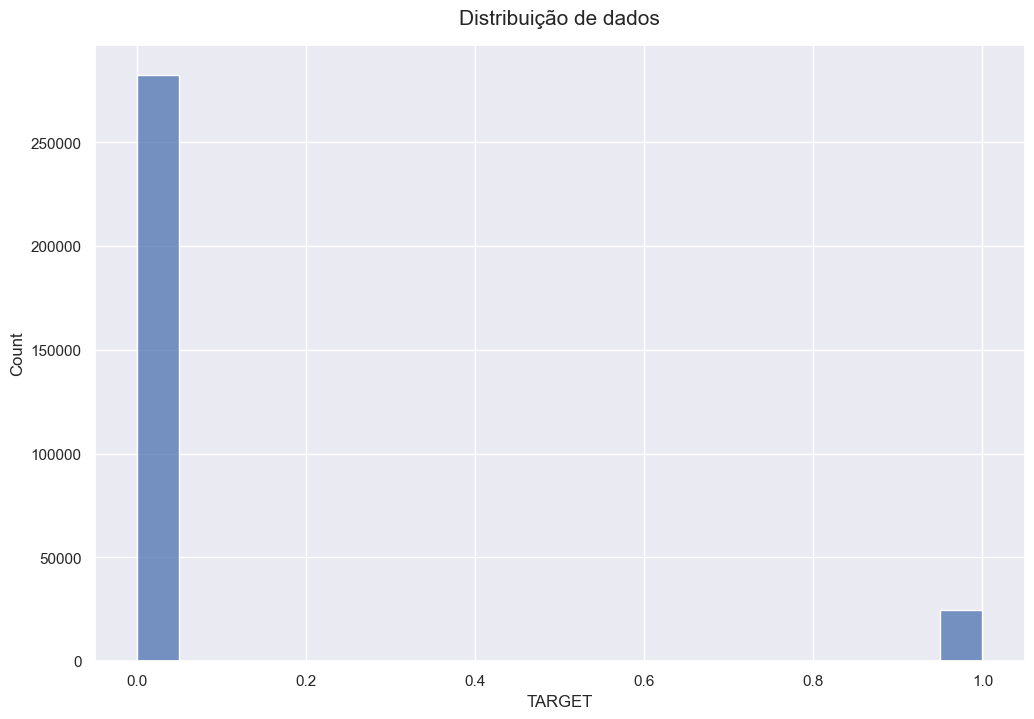

In [16]:
sns.histplot(data['TARGET'])
plt.title('Distribuição de dados',size=15,pad=15);

Nota-se um claro desbalanceamento nos dados em relação à variável alvo.

#### 2.1.2 Variáveis Numéricas

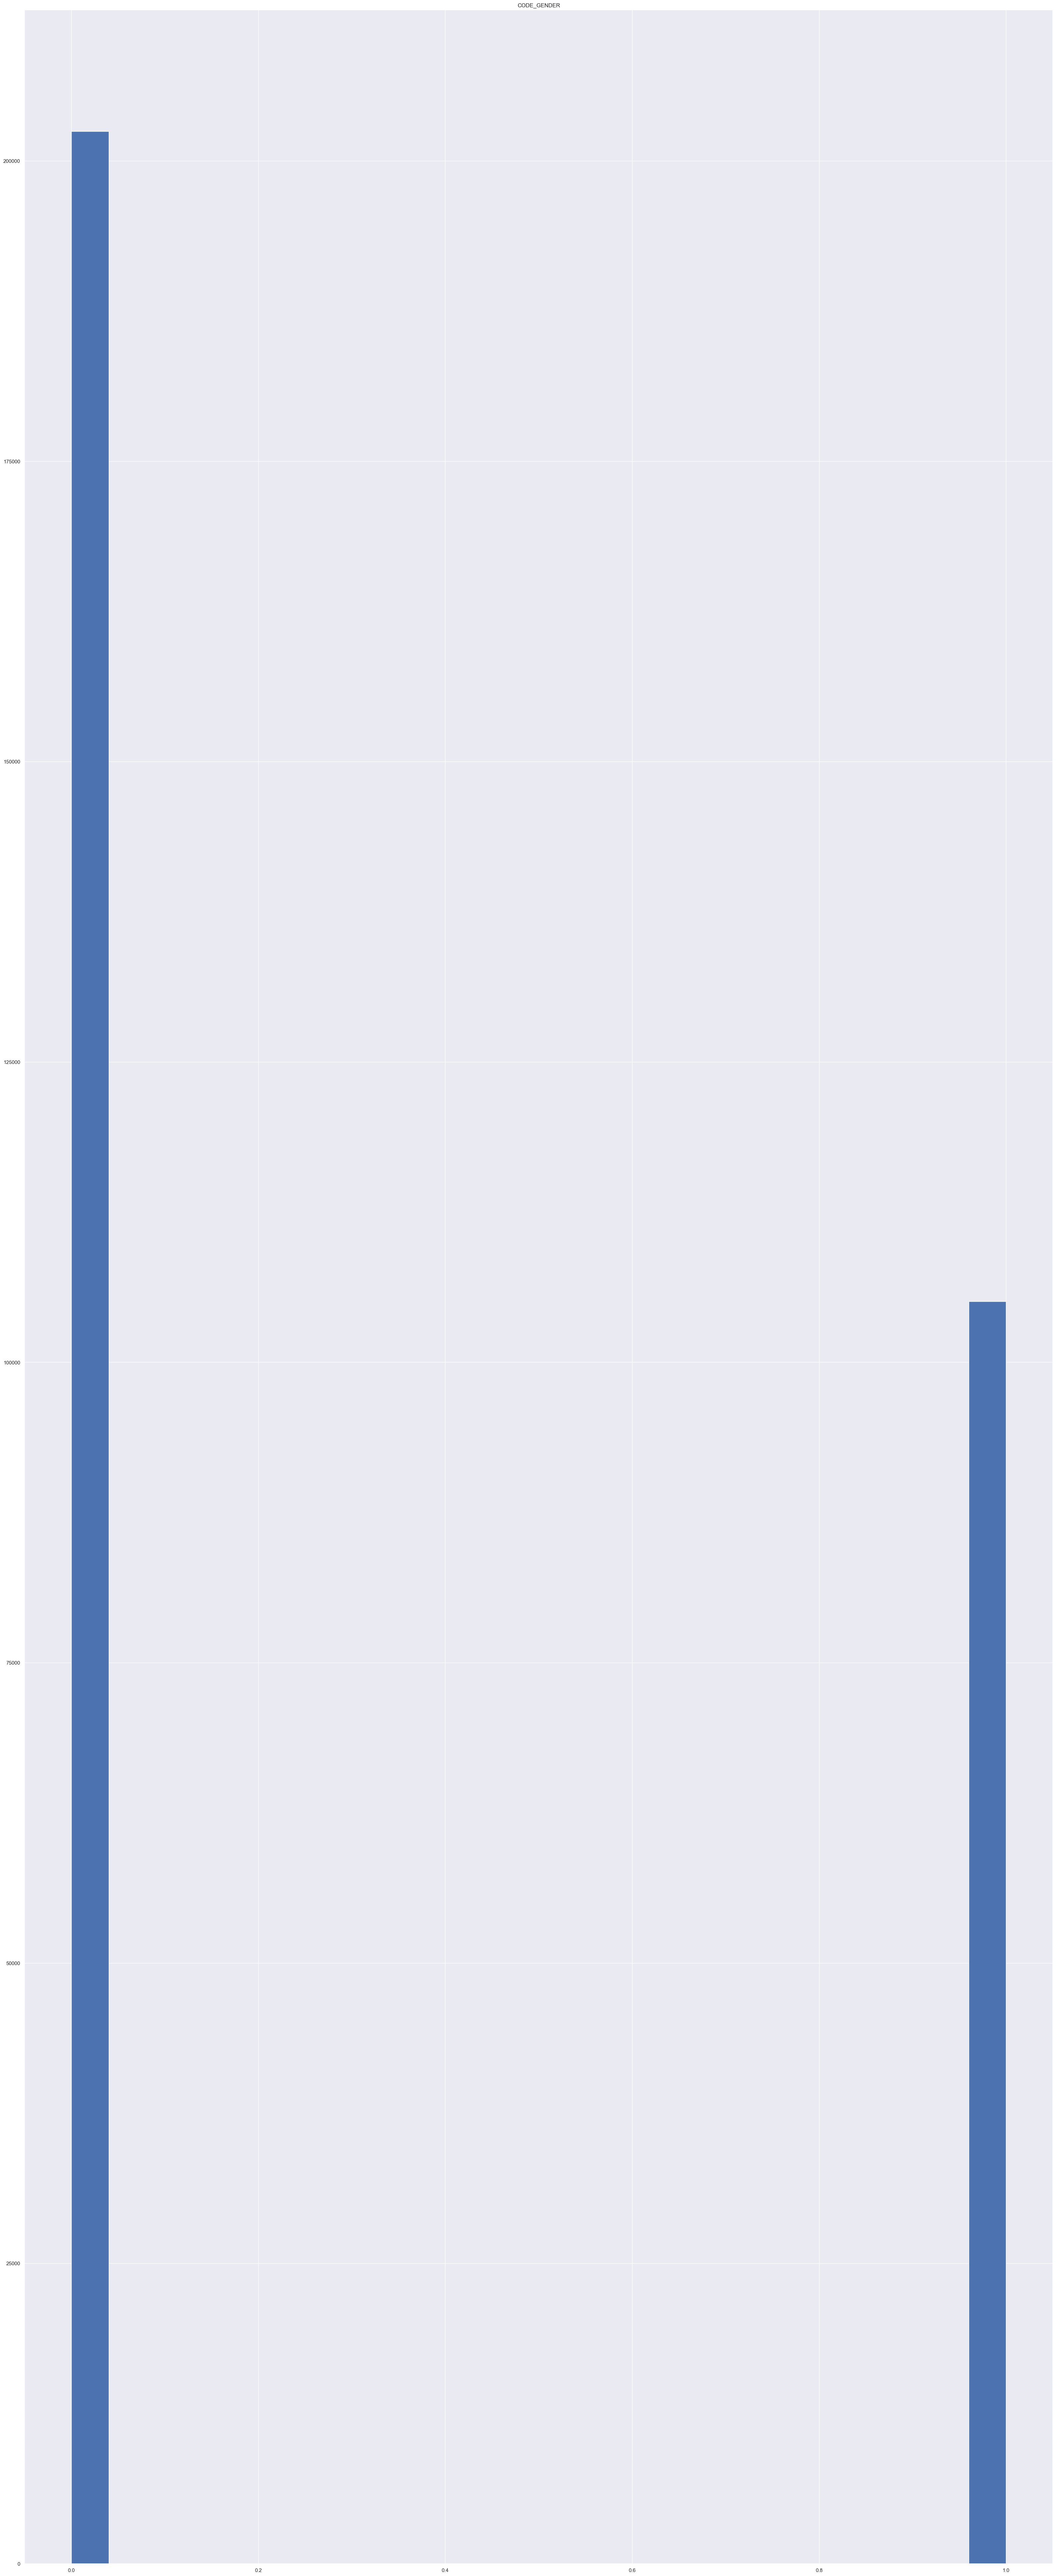

In [17]:
num_attributes.hist(figsize=(40,100), bins=25);

### 2.2 Correlação

O coeficiente de correlação de Pearson avalia o grau e a direção da correlação linear entre duas variáveis. Deste modo, quanto mais próximos de 1 ou -1, maior a intensidade da correlação, o sinal indica apenas a direção (positivamente correlacionados ou negativamente correlacionados). Deve-se mencionar também que quanto mais próximo de 0 menor a força da correlação.

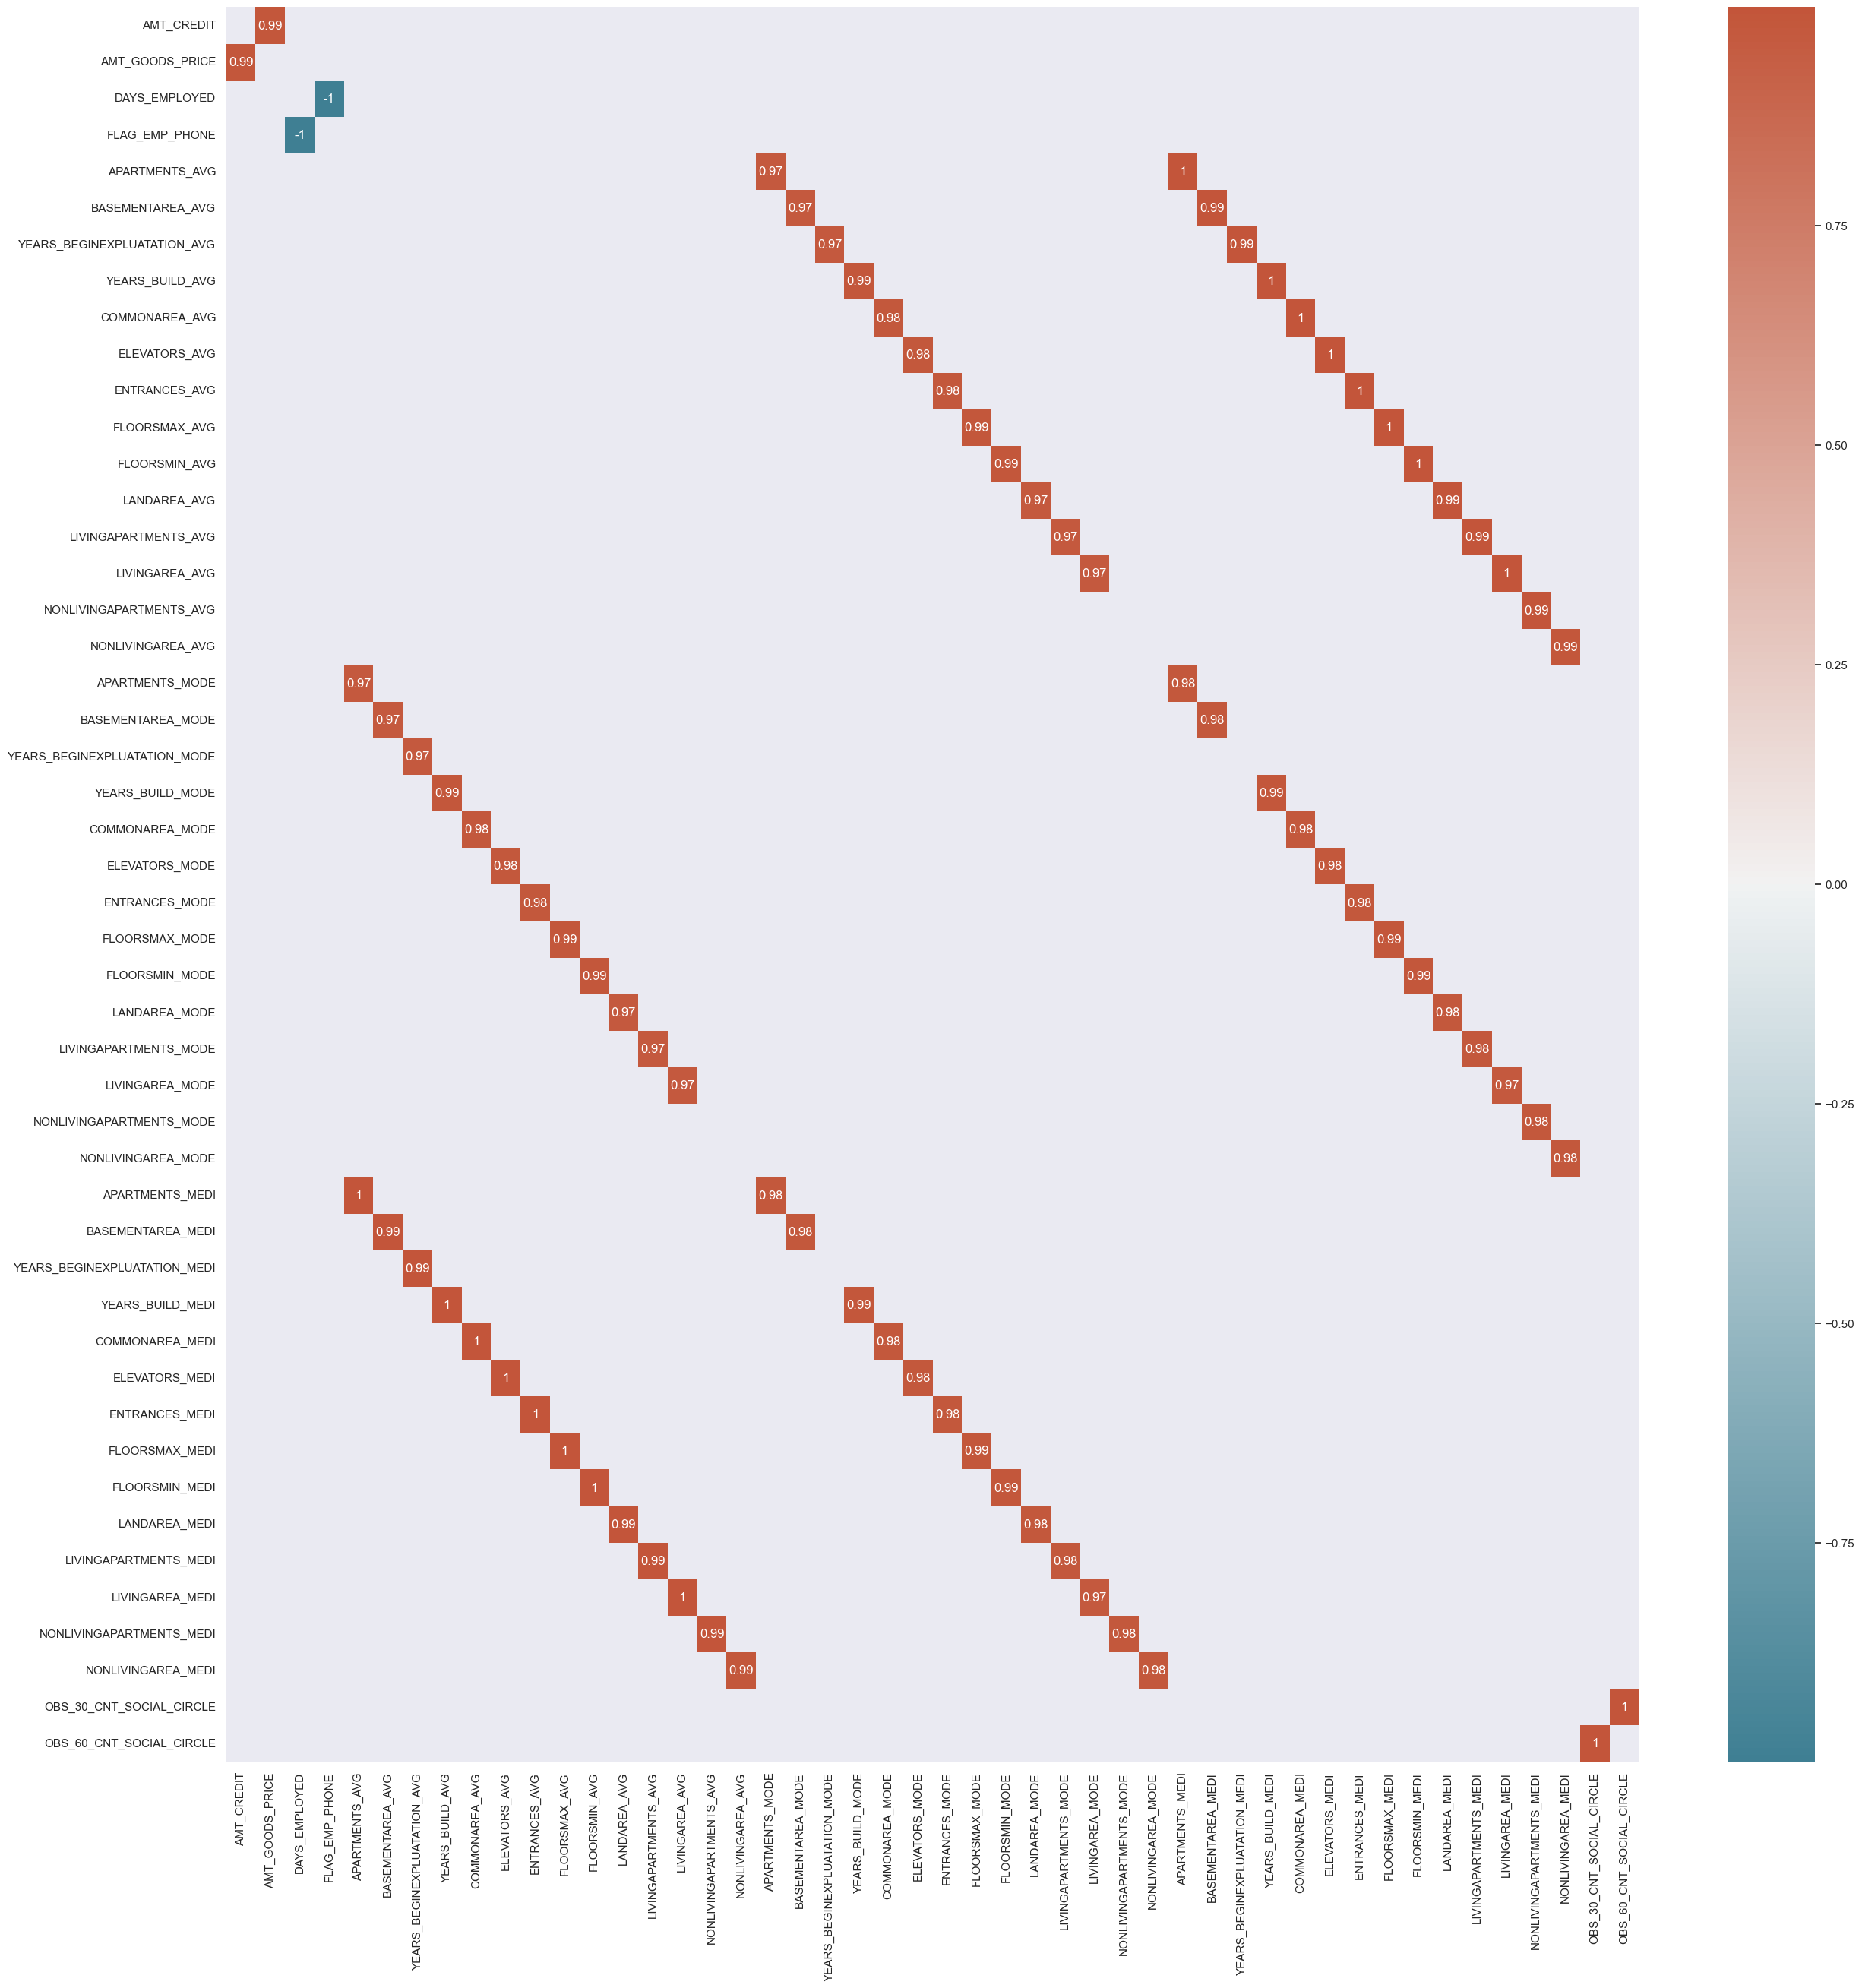

In [18]:
plt.figure(figsize=(30,30))
corr_data = data.corr()
corr_data = pd.DataFrame(data.corr(), columns=corr_data.columns)
corr_data = corr_data[((corr_data!=1)) & ((corr_data > 0.97) | (corr_data < -0.85))]
corr_data.dropna(axis=1, how='all',inplace=True) 
corr_data.dropna(axis=0, how='all',inplace=True) 
sns.heatmap(corr_data,xticklabels=corr_data.columns,yticklabels=corr_data.columns,annot=True,cmap=sns.diverging_palette(220,20, as_cmap=True));

Podem-se identificar diversas correlações lineares entre algumas variáveis.



### 2.3 Análise Bivariada


#### Existe alguma diferença entre os bons e maus pagantes em função do gênero?

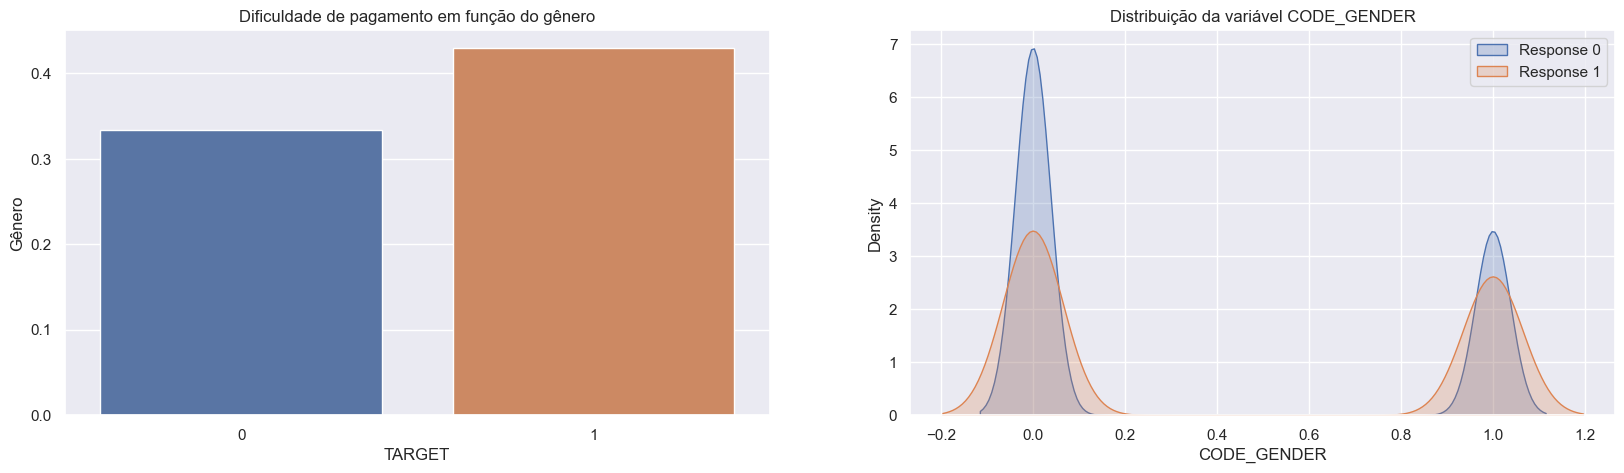

In [19]:
plt.figure(figsize=(20,5))
plt.subplot(1, 2, 1)
sns.barplot(x=data.groupby('TARGET').CODE_GENDER.mean().index,y=data.groupby('TARGET').CODE_GENDER.mean().values);
plt.title('Dificuldade de pagamento em função do gênero');
plt.ylabel('Gênero')

plt.subplot(1, 2, 2)
sns.kdeplot(data[data.TARGET == 0].CODE_GENDER,label='Response 0',shade=True);
sns.kdeplot(data[data.TARGET == 1].CODE_GENDER,label='Response 1',shade=True);
plt.title('Distribuição da variável CODE_GENDER')
plt.legend();

No gráfico à esquerda, podemos notar a dificuldade de pagamento (TARGET = 0 e TARGET = 1) em função do gênero. No gráfico à direita, notamos a distribuição para a variável `CODE_GENDER`.

Verifica-se que:
* A quantidade de homens que tiveram dificuldade de pagamento (TARGET = 1) foi maior que a quantidade de mulheres.

#### Existe alguma diferença entre os bons e maus pagantes em função do tipo de contrato?

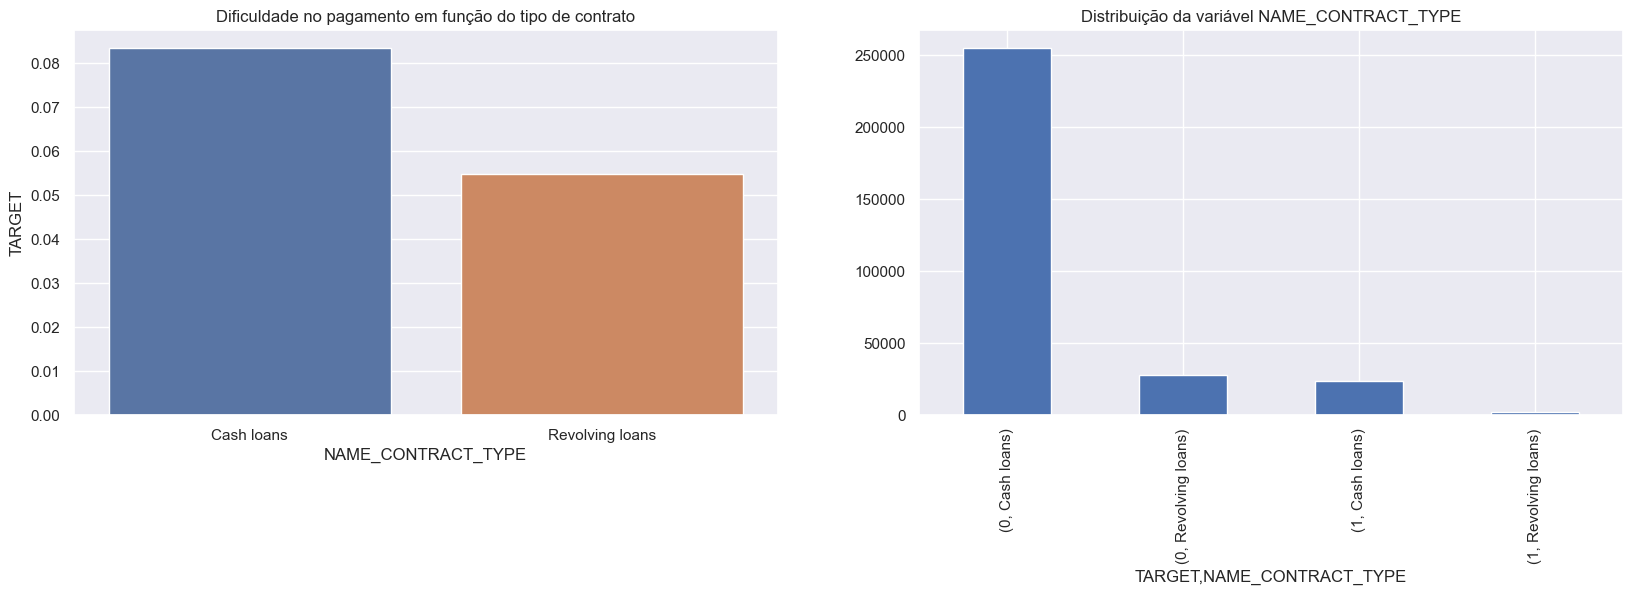

In [20]:
plt.figure(figsize=(20,5))
plt.subplot(1, 2, 1)
sns.barplot(x=data.groupby('NAME_CONTRACT_TYPE').TARGET.mean().index,y=data.groupby('NAME_CONTRACT_TYPE').TARGET.mean().values);
plt.title('Dificuldade no pagamento em função do tipo de contrato');
plt.ylabel('TARGET');

plt.subplot(1, 2, 2)
data.groupby('TARGET').NAME_CONTRACT_TYPE.value_counts().plot(kind='bar');
plt.title('Distribuição da variável NAME_CONTRACT_TYPE');

No gráfico à esquerda, podemos notar a dificuldade no pagamento em função do tipo de contrato. No gráfico à direita, notamos a distribuição para a variável `NAME_CONTRACT_TYPE`.

Verificamos que:
* Os empréstimos que tiveram maior dificuldade no pagamento foram em dinheiro. 
* Os clientes se interessaram bem mais por empréstimo em dinheiro do que empréstimos rotativos.

#### Existe alguma diferença entre os bons e maus pagantes em função da renda do cliente?

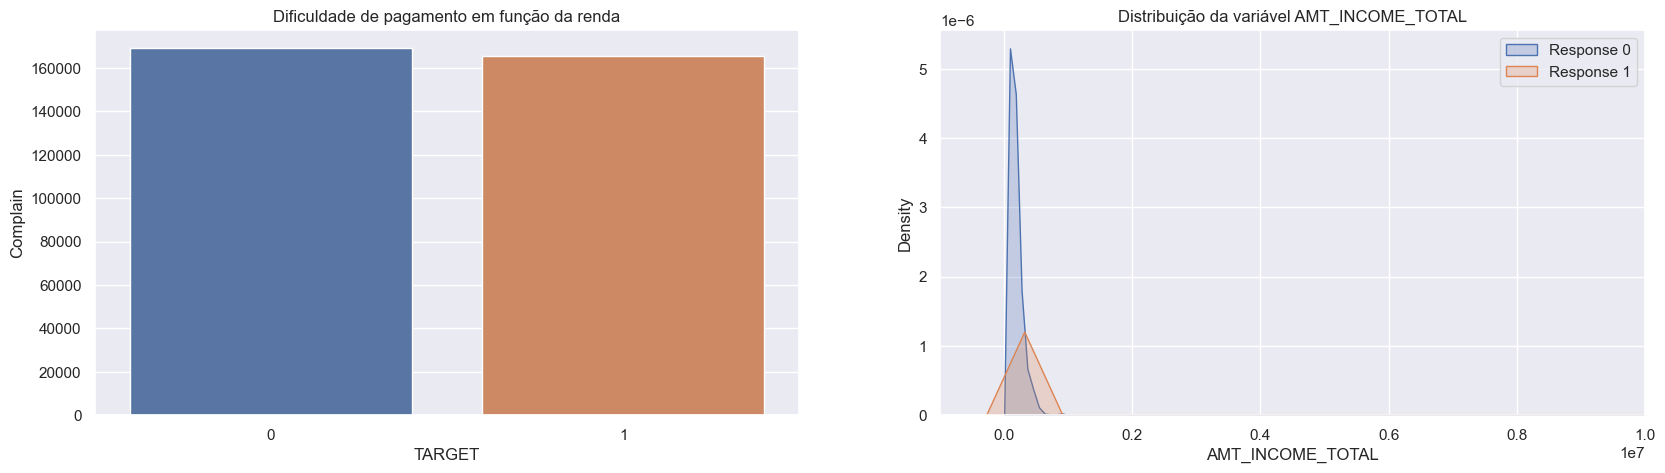

In [21]:
plt.figure(figsize=(20,5))
plt.subplot(1, 2, 1)
sns.barplot(x=data.groupby('TARGET').AMT_INCOME_TOTAL.mean().index,y=data.groupby('TARGET').AMT_INCOME_TOTAL.mean().values);
plt.title('Dificuldade de pagamento em função da renda');
plt.ylabel('Complain');

plt.subplot(1, 2, 2)
sns.kdeplot(data[data.TARGET == 0].AMT_INCOME_TOTAL,label='Response 0',shade=True);
sns.kdeplot(data[data.TARGET == 1].AMT_INCOME_TOTAL,label='Response 1',shade=True);
plt.xlim((-1e6,1e7)) # Selecionando apenas esta região do gráfico para identificar melhor as diferenças nas distribuições
plt.title('Distribuição da variável AMT_INCOME_TOTAL')
plt.legend();

No gráfico à esquerda, podemos notar a dificuldade de pagamento dos empréstimos em função da renda do cliente. No gráfico à direita, notamos a distribuição para a variável `AMT_INCOME_TOTAL`.

Verificamos que:
* O grupo que teve maior maior dificuldade no pagamento teve menor renda. Entretanto, essa diferença foi bem pequena.

# 3. Preparação dos Dados

## 3.1 Criação de Colunas

In [22]:
data      = create_age_column(data)
data      = create_years_employed_column(data)
data      = create_years_id_publish_column(data)
data      = fix_days_employed_column(data)
data      = fix_days_registration_column(data)
data      = fix_days_last_phone_change_column(data)
data_base = data.copy()

## 3.2 Identificando variáveis Categóricas e Numéricas

In [23]:
num_attributes = data.select_dtypes(include=['int32', 'int8', 'int64', 'float64', 'float32', 'float16'])
cat_attributes = data.select_dtypes(exclude=['int32', 'int8', 'int64', 'float64', 'float32', 'float16', 'datetime64[ns]'])

## 3.3 Split dos Dados

In [24]:
X_train = data.drop(columns=['TARGET'])
y_train = data.TARGET
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.2, random_state=0)

## 3.4 Imputações de Dados

In [25]:
X_train_feature_selection = X_train.copy()
X_test_feature_selection  = X_test.copy()

# Imputação de dados no conjunto de treino
imp_mean = SimpleImputer(missing_values=np.nan, strategy='mean')
# imp_mean = SimpleImputer(missing_values=np.nan, fill_value=0)
imputer = imp_mean.fit(X_train_feature_selection[num_attributes.columns.drop('TARGET')])
X_train_feature_selection[num_attributes.columns.drop('TARGET')] = imputer.transform(X_train_feature_selection[num_attributes.columns.drop('TARGET')])

# imputer_most_frequent = SimpleImputer(strategy='most_frequent', missing_values=np.nan)
imputer_most_frequent = SimpleImputer(missing_values=np.nan, strategy='constant', fill_value=0)
imputer = imputer_most_frequent.fit(X_train_feature_selection[cat_attributes.columns])
X_train_feature_selection[cat_attributes.columns] = imputer.transform(X_train_feature_selection[cat_attributes.columns])

# Imputação de dados no conjunto de teste
imp_mean = SimpleImputer(missing_values=np.nan, strategy='mean')
# imp_mean = SimpleImputer(missing_values=np.nan, fill_value=0)
imputer = imp_mean.fit(X_test_feature_selection[num_attributes.columns.drop('TARGET')])
X_test_feature_selection[num_attributes.columns.drop('TARGET')] = imputer.transform(X_test_feature_selection[num_attributes.columns.drop('TARGET')])

# imputer_most_frequent = SimpleImputer(strategy='most_frequent', missing_values=np.nan)
imputer_most_frequent = SimpleImputer(missing_values=np.nan, strategy='constant', fill_value=0)
imputer = imputer_most_frequent.fit(X_test_feature_selection[cat_attributes.columns])
X_test_feature_selection[cat_attributes.columns] = imputer.transform(X_test_feature_selection[cat_attributes.columns])

## 3.5 Inserindo novos Dados

### 3.5.1 Modelagem de Dados

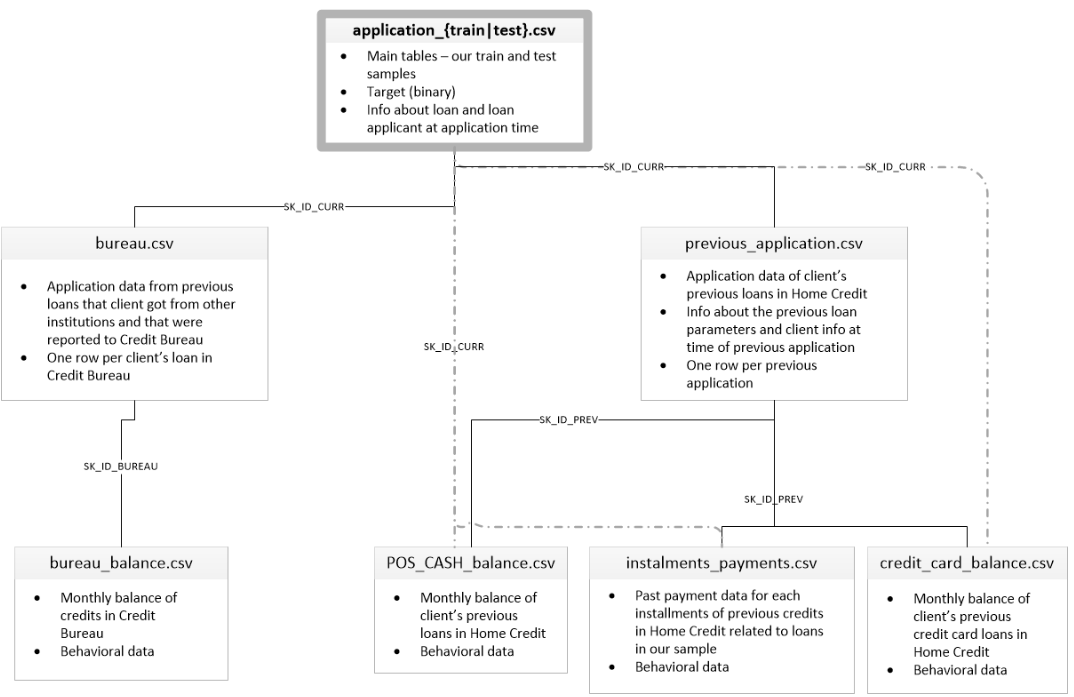

In [26]:
Image('images\data.png')

### 3.5.2 Identificando os caminhos

In [27]:
path_bureau                = './data/bureau.csv'
path_bureau_balance        = './data/bureau_balance.csv'
path_credit_card_balance   = './data/credit_card_balance.csv'
path_installments_payments = './data/installments_payments.csv'
path_POS_CASH_balance      = './data/POS_CASH_balance.csv'
path_previous_application  = './data/previous_application.csv'
path_test                  = './data/test.csv'

### 3.5.3 Importando dados

In [28]:
data_bureau                = load_csv(path_bureau)
data_bureau_balance        = load_csv(path_bureau_balance)
data_credit_card_balance   = load_csv(path_credit_card_balance)
data_installments_payments = load_csv(path_installments_payments)
data_POS_CASH_balance      = load_csv(path_POS_CASH_balance)
data_previous_application  = load_csv(path_previous_application)
data_test                  = load_csv(path_test)

In [29]:
data_bureau                = reduce_memory(data_bureau)
data_bureau_balance        = reduce_memory(data_bureau_balance)
data_credit_card_balance   = reduce_memory(data_credit_card_balance)
data_installments_payments = reduce_memory(data_installments_payments)
data_POS_CASH_balance      = reduce_memory(data_POS_CASH_balance)
data_previous_application  = reduce_memory(data_previous_application)
data_test                  = reduce_memory(data_test)

Initial df memory usage is 222.62 MB for 17 columns
Final memory usage is: 112.95 MB - decreased by 49.3%
Initial df memory usage is 624.85 MB for 3 columns
Final memory usage is: 338.46 MB - decreased by 45.8%
Initial df memory usage is 673.88 MB for 23 columns
Final memory usage is: 289.33 MB - decreased by 57.1%
Initial df memory usage is 830.41 MB for 8 columns
Final memory usage is: 311.40 MB - decreased by 62.5%
Initial df memory usage is 610.43 MB for 8 columns
Final memory usage is: 238.45 MB - decreased by 60.9%
Initial df memory usage is 471.48 MB for 37 columns
Final memory usage is: 309.01 MB - decreased by 34.5%
Initial df memory usage is 45.00 MB for 121 columns
Final memory usage is: 14.60 MB - decreased by 67.6%


### 3.5.4 Filtrando dados para apenas os dois últimos anos

In [ ]:
data_bureau = data_bureau[ - data_bureau.DAYS_CREDIT <= 2*365] 
data_previous_application = data_previous_application[ - data_previous_application.DAYS_DECISION <= 2*365]

In [ ]:
import gc

In [ ]:
data_agg_bureau = data_bureau.merge(data_bureau_balance,on='SK_ID_BUREAU',how='left')
del data_bureau; gc.collect()
del data_bureau_balance; gc.collect()
data = data.merge(data_agg_bureau,on='SK_ID_CURR',how='left')
del data_agg_bureau; gc.collect()
data_agg_previous_application = data_previous_application.merge(data_POS_CASH_balance,on='SK_ID_PREV',how='left')
del data_previous_application; gc.collect()
del data_POS_CASH_balance; gc.collect()
data_agg_previous_application = data_agg_previous_application.merge(data_installments_payments,on='SK_ID_PREV',how='left')
del data_installments_payments; gc.collect()
data_agg_previous_application = data_agg_previous_application.merge(data_credit_card_balance,on='SK_ID_PREV',how='left')
del data_credit_card_balance; gc.collect()
data = data.merge(data_agg_previous_application,on='SK_ID_CURR',how='left')
del data_agg_previous_application; gc.collect()

### 3.6 Remoção de Coluna

In [ ]:
data = drop_id_column(data)

### 3.7 Encoding

In [ ]:
# ----------------------------------------- SEM IMPUTAÇÃO DE DADOS --------------------------------------------- #
# Aplicação do encoding nos dados de treino
encoder = TargetEncoder()
X_train_encoded = encoder.fit_transform(X_train, y_train)
# Aplicação do encoding nos dados de teste
X_test_encoded  = encoder.transform(X_test,y_test)

# ----------------------------------------- COM IMPUTAÇÃO DE DADOS --------------------------------------------- #

# Aplicação do encoding nos dados de treino
encoder = TargetEncoder()
X_train_feature_selection_encoded = encoder.fit_transform(X_train_feature_selection, y_train)
# Aplicação do encoding nos dados de teste
X_test_feature_selection_encoded  = encoder.transform(X_test_feature_selection,y_test)

## 3.8 Seleção de variáveis

### 3.8.1 Random Forest e RFECV para Feature Selection

In [ ]:
# features = X_train_encoded.columns
# rf = RandomForestClassifier(random_state=0)
# rf.fit(X_train_encoded,y_train_feature_selection);

In [ ]:
# # Método de Seleção de Variáveis RFE - Embora seja robusto demanda bastante esforço computacional devido ao processo iterativo
# rfe = RFECV(rf,cv=3,scoring="roc_auc",step=25)

# rfe.fit(X_train_encoded,y_train_feature_selection)

# selected_features = np.array(features)[rfe.get_support()]

# X_train_selected = X_train_encoded[selected_features]

### 3.8.2 Visualização Gráfica - Importância das Features

In [ ]:
# Para visualizar graficamente as importâncias das features deve-se descomentar as linhas abaixo

# f_i = list(zip(features,rf.feature_importances_))
# f_i.sort(key = lambda x : x[1])
# plt.barh([x[0] for x in f_i],[x[1] for x in f_i])

# plt.show()

### 3.8.3 SelectKBest para Feature Selection

In [ ]:
from sklearn.feature_selection import SelectKBest, mutual_info_classif
select_var = SelectKBest(mutual_info_classif, k=30)
select_var.fit_transform(X_train_feature_selection_encoded, y_train)
cols = select_var.get_support(indices=True)

In [ ]:
X_train_features_selected_without_imputation = X_train_encoded.iloc[:,cols]
X_test_features_selected_without_imputation  = X_test_encoded.iloc[:,cols]
X_train_features_selected_with_imputation    = X_train_feature_selection_encoded.iloc[:,cols]
X_test_features_selected_with_imputation     = X_test_feature_selection_encoded.iloc[:,cols]

# 4. Modelos de Machine Learning

Modelos testados:

* LogisticRegression();
* DecisionTreeClassifier();
* RandomForestClassifier();
* AdaBoostClassifier();
* GradientBoostingClassifier();
* XGBClassifier();
* lgb.LGBMClassifier();
* CatBoostClassifier()

In [ ]:
classifiers_distance_based = [
    # KNeighborsClassifier(3),
    # SVC(),
    LogisticRegression()
]
classifiers_tree_based = [
    DecisionTreeClassifier(),
    RandomForestClassifier(),
    AdaBoostClassifier(),
    GradientBoostingClassifier(),
    XGBClassifier(),
    lgb.LGBMClassifier(),
    CatBoostClassifier(verbose=False)
]

preprocessor = ColumnTransformer([
    ('standardization', StandardScaler(), X_train_features_selected_with_imputation.columns)
])

# Loop para os classificadores que levam em consideração a distância entre os pontos - necessitam de standardização
for classifier in classifiers_distance_based:
    pipe = Pipeline(steps=[("preprocessor", preprocessor), ("classifier", classifier)])
    pipe.fit(X_train_features_selected_with_imputation, y_train)
    ypred = pipe.predict(X_test_features_selected_with_imputation)
    # Computa probabilidades
    y_pred_prob = pipe.predict_proba(X_test_features_selected_with_imputation)[:,1]
    print(classifier)
    print("model score: %.3f" % pipe.score(X_test_features_selected_with_imputation, y_test))
    print("model roc_auc_score: %.3f" % roc_auc_score(y_test,y_pred_prob))
    print("model classification report")
    print(classification_report(y_test, ypred))

# Loop para os classificadores baseados em árvore de decisão - não necessitam de standardização
for classifier in classifiers_tree_based:
    pipe = Pipeline(steps=[("classifier", classifier)])
    pipe.fit(X_train_features_selected_with_imputation, y_train)
    ypred = pipe.predict(X_test_features_selected_with_imputation)
    # Computa probabilidades
    y_pred_prob = pipe.predict_proba(X_test_features_selected_with_imputation)[:,1]
    print(classifier)
    print("model score: %.3f" % pipe.score(X_test_features_selected_with_imputation, y_test))
    print("model roc_auc_score: %.3f" % roc_auc_score(y_test,y_pred_prob))
    print("model classification report")
    print(classification_report(y_test, ypred))

## 4.1 Model Tuning

Após a escolha do modelo para este projeto: `LightGBM`. A escolha deste modelo trás uma série de benefícios, dentre eles: a habilidade de lidar com dados ausentes. Em virtude disto, no primeiro momento será realizada a comparação entre o desempenho do modelo sem imputação de dados e com imputação de dados.

In [ ]:
classifier = lgb.LGBMClassifier(class_weight='balanced')

print('# ----------------- MODELO SEM IMPUTAÇÃO DE DADOS ----------------------------------------- #')
pipe = Pipeline(steps=[("classifier", classifier)])
pipe.fit(X_train_features_selected_without_imputation, y_train)
ypred = pipe.predict(X_test_features_selected_without_imputation)
# Computa probabilidades
y_pred_prob = pipe.predict_proba(X_test_features_selected_without_imputation)[:,1]
print(classifier)
print("model score: %.3f" % pipe.score(X_test_features_selected_without_imputation, y_test))
print("model roc_auc_score: %.3f" % roc_auc_score(y_test,y_pred_prob))
print("model classification report")
print(classification_report(y_test, ypred))

print('# ---------------- MODELO COM IMPUTAÇÃO DE DADOS ------------------------------------------ #')
pipe = Pipeline(steps=[("classifier", classifier)])
pipe.fit(X_train_features_selected_with_imputation, y_train)
ypred = pipe.predict(X_test_features_selected_with_imputation)
# Computa probabilidades
y_pred_prob = pipe.predict_proba(X_test_features_selected_with_imputation)[:,1]
print(classifier)
print("model score: %.3f" % pipe.score(X_test_features_selected_with_imputation, y_test))
print("model roc_auc_score: %.3f" % roc_auc_score(y_test,y_pred_prob))
print("model classification report")
print(classification_report(y_test, ypred))

Percebe-se que o modelo em que os dados não foram imputados apresentou melhor desempenho comparado ao outro. Dessa forma, prosseguiremos com o modelo de melhor desempenho. Neste momento ser realizada a otimização dos hyperparâmetros do `LightGBM`.

In [ ]:
classifier = lgb.LGBMClassifier(class_weight='balanced')

print('# ----------------- MODELO SEM IMPUTAÇÃO DE DADOS ----------------------------------------- #')
pipe = Pipeline(steps=[("classifier", classifier)])
pipe.fit(X_train_features_selected_without_imputation, y_train)
ypred = pipe.predict(X_test_features_selected_without_imputation)
# Computa probabilidades
y_pred_prob = pipe.predict_proba(X_test_features_selected_without_imputation)[:,1]
print(classifier)
print("model score: %.3f" % pipe.score(X_test_features_selected_without_imputation, y_test))
print("model roc_auc_score: %.3f" % roc_auc_score(y_test,y_pred_prob))
print("model classification report")
print(classification_report(y_test, ypred))

# Visualizar a curva ROC

# Gera fpr, tpr e thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
auc_value = roc_auc_score(y_test, y_pred_prob)
plt.plot(fpr, tpr, color='blue', label='ROC curve (area = %0.2f)' % auc_value)

# curva ROC
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

# 5. Salvando Modelo em Pickle

In [ ]:
# ----------------------- Exportando o modelo com melhor resultado ----------------------- #
# ----------------------- MODELO - SEM IMPUTAÇÃO DE DADOS -------------------------------- #

# Fittando o melhor modelo
pipe.fit(X_train_features_selected_without_imputation, y_train)

# Exportando o modelo final para implantação
import pickle

pickle.dump(pipe, open('./models/pipe.pkl', 'wb'))